# Character analysis of a TEI-encoded corpus
---

This Jupyter Notebook can be used to compute basic descriptive statistics and network statistics about characters and character relations in a corpus of TEI-encoded plays, either loaded from a local file or from [DraCor](https://dracor.org). The procedure is divided in three steps:

1.   Preparation
2.   Data extraction
3.   Analysis and visualisation

## Step 1. Prepare analysis
---
### 1.1 Load modules

In [ ]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from urllib.request import urlopen
import time
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from string import punctuation
from networkx import betweenness_centrality
from networkx import density

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Step 2. Define filepaths

### 1.2 Define filepath or data source

Before you run the code blocks below, make sure to add a shortcut from the shared folder 'KB_workshop_280324' to the home directory of your My Drive by following these steps:

1.   Richt click on the folder name 'KB_workshop_280324'
2.   Select 'Organize'
3.   Select 'Add shortcut'
4.   Select 'My Drive' under 'All locations' and click 'Add'.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


If you succesfully created a shortcut, then the code block below should return:


```
['Corpus', 'Notebooks']
```

If it doesn't, then try to adjust the filepath to the directory structure of your Google Drive untill it does.

In [ ]:
home_dir = '/content/gdrive/MyDrive/KB_workshop_280324/'
os.listdir(home_dir)

['Corpus',
 'Notebooks',
 'Data',
 "KB workshop 'Computationeel toneelonderzoek' 28 maart 2024.pptx",
 'Scripts']

Define filepath to the location of your personal output by defining the variable `your_name`.

In [ ]:
your_name = "Lucas"
output_folder =  home_dir + "Notebooks/" + your_name + "/Data/"

Select the corpus or corpora you would like to analyse by removing the irrelevant corpora from the list `corpora` in the code block below.

In [ ]:
corpora = ["DutchDraCor_180"] # choose between (a combination of) "1610", "Vondel", "NVA", "Katharinas", "Van_Merken", "DutchDraCor", "DutchDraCor_180"
list_of_titles = []
for corpus in corpora:
  for title in os.listdir(home_dir + "Corpus/" + corpus + "/"):
    list_of_titles.append((title, corpus))
print(len(list_of_titles), "plays have been selected for analysis.")

180 plays have been selected for analysis.


In [ ]:
list_of_titles

[('merken-gelonide.xml', 'DutchDraCor_180'),
 ('hooft-baeto.xml', 'DutchDraCor_180'),
 ('lescailje-herkules-en-dianira.xml', 'DutchDraCor_180'),
 ('merken-jacob-simonszoon-de-ryk.xml', 'DutchDraCor_180'),
 ('koning-achabs.xml', 'DutchDraCor_180'),
 ('nva-agrippa.xml', 'DutchDraCor_180'),
 ('merken-de-camisards.xml', 'DutchDraCor_180'),
 ('lescailje-kassandra.xml', 'DutchDraCor_180'),
 ('koning-iephthahs.xml', 'DutchDraCor_180'),
 ('nva-astrate.xml', 'DutchDraCor_180'),
 ('koning-simsons.xml', 'DutchDraCor_180'),
 ('krul-theodorus-en-dianira.xml', 'DutchDraCor_180'),
 ('merken-sebille-van-anjou.xml', 'DutchDraCor_180'),
 ('lescailje-genserik.xml', 'DutchDraCor_180'),
 ('coster-isabella.xml', 'DutchDraCor_180'),
 ('lescailje-herodes-en-mariamne.xml', 'DutchDraCor_180'),
 ('merken-louize-d-arlac.xml', 'DutchDraCor_180'),
 ('krul-cloris-en-philida.xml', 'DutchDraCor_180'),
 ('lescailje-nicomedes.xml', 'DutchDraCor_180'),
 ('krul-alcip-en-amarillis.xml', 'DutchDraCor_180'),
 ('coster-ithys.

### 1.3 Define functions

Run the block below to load the required functions.

In [ ]:
def create_speakersdict(root_play):
    speakers_dict = {}
    speaker_list = [persona for persona in root_play.findall(".//{http://www.tei-c.org/ns/1.0}personGrp") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}person")]
    for speaker in speaker_list:
        speaker_id = speaker.get("{http://www.w3.org/XML/1998/namespace}id")
        if speaker.find(".//{http://www.tei-c.org/ns/1.0}name") != None:
          name = speaker.find(".//{http://www.tei-c.org/ns/1.0}name").text
        else:
          name = speaker.find(".//{http://www.tei-c.org/ns/1.0}persName").text
        speakers_dict[speaker_id] = {}
        speakers_dict[speaker_id]["name"] = name
        speakers_dict[speaker_id]["gender"] = speaker.get("sex")
        speakers_dict[speaker_id]["act_appearances"] = 0
        speakers_dict[speaker_id]["scene_appearances"] = 0
        speakers_dict[speaker_id]["speech_turns"] = 0
        speakers_dict[speaker_id]["lines"] = 0
        speakers_dict[speaker_id]["act_PRO"] = 0
        speakers_dict[speaker_id]["act_1"] = 0
        speakers_dict[speaker_id]["act_2"] = 0
        speakers_dict[speaker_id]["act_3"] = 0
        speakers_dict[speaker_id]["act_4"] = 0
        speakers_dict[speaker_id]["act_5"] = 0
        speakers_dict[speaker_id]["act_6"] = 0
        speakers_dict[speaker_id]["all_lines"] = []
    return(speakers_dict)

def extract_speechturns(list_of_scenes, play_has_acts, act_ID):
    for scene in list_of_scenes:
            scene_ID = "scene_" + scene.get("n")
            if play_has_acts:
                lines_dict[act_ID][scene_ID] = {}
            else:
                lines_dict[scene_ID] = {}
            speech_turns = [speech for speech in scene.findall(".//{http://www.tei-c.org/ns/1.0}sp")]
            speakers_in_scene = set([])

            for speech_turn in speech_turns:
                speaker_element = speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}speaker")

                if speech_turn.get("who") == None:
                  speaker_id = "UNKNOWN"
                else:
                  speaker_id = speech_turn.get("who").replace("#", "")

                if play_has_acts:
                    speakers_in_act.add(speaker_id)
                speakers_in_scene.add(speaker_id)
                speakers_in_act.add(speaker_id)
                lines = speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}lb") + speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}l") + speech_turn.findall(".//{http://www.tei-c.org/ns/1.0}s")

                if speaker_id not in speakers_dict:
                    speakers_dict[speaker_id] = {}
                    speakers_dict[speaker_id]["name"] = "UNKNOWN"
                    speakers_dict[speaker_id]["gender"] = "u"
                    speakers_dict[speaker_id]["act_appearances"] = 0
                    speakers_dict[speaker_id]["scene_appearances"] = 0
                    speakers_dict[speaker_id]["speech_turns"] = 0
                    speakers_dict[speaker_id]["lines"] = 0
                    speakers_dict[speaker_id]["act_PRO"] = 0
                    speakers_dict[speaker_id]["act_1"] = 0
                    speakers_dict[speaker_id]["act_2"] = 0
                    speakers_dict[speaker_id]["act_3"] = 0
                    speakers_dict[speaker_id]["act_4"] = 0
                    speakers_dict[speaker_id]["act_5"] = 0
                    speakers_dict[speaker_id]["act_6"] = 0
                    speakers_dict[speaker_id]["all_lines"] = []
                speakers_dict[speaker_id]["speech_turns"] += 1
                speakers_dict[speaker_id]["lines"] += len(lines)

                lines_in_sp = [line.text for line in lines]
                speakers_dict[speaker_id]["all_lines"] += lines_in_sp

                if play_has_acts:
                  speakers_dict[speaker_id][act_ID] += len(lines)
                  if speaker_id not in lines_dict[act_ID][scene_ID]:
                        lines_dict[act_ID][scene_ID][speaker_id] = len(lines)
                  else:
                        lines_dict[act_ID][scene_ID][speaker_id] += len(lines)
                else:
                    if speaker_id not in lines_dict[scene_ID]:
                        lines_dict[scene_ID][speaker_id] = len(lines)
                    else:
                        lines_dict[scene_ID][speaker_id] += len(lines)
            for speaker_id in list(set(speakers_in_scene)):
                speakers_dict[speaker_id]["scene_appearances"] += 1

def generate_edges(speaker_ids):
    for source_id in speaker_ids:
            if source_id not in edges_dict:
                edges_dict[source_id] = {}
            for target_id in speaker_ids:
                if target_id != source_id:
                    if target_id in edges_dict:
                        if source_id in edges_dict[target_id]:
                            ()
                        elif target_id not in edges_dict[source_id]:
                            edges_dict[source_id][target_id] = 1
                        else:
                            edges_dict[source_id][target_id] += 1
                    elif target_id not in edges_dict[source_id]:
                        edges_dict[source_id][target_id] = 1
                    else:
                        edges_dict[source_id][target_id] += 1

## Step 2. Extract data

Before we can analyse the plays, we need to extract all information about the plays and the characters stored in the TEI-files. The long code block below processes all the files in the selected corpus folder(s) and stores the information in two dataframes (= tables): `df_plays` and `df_characters`.

In [ ]:
headers_metadata = ["play_id", "corpus", "author", "title", "genre", "year", "characters", "male", "female", "%_male_chars", "%_female_chars", "%_female_lines", "acts", "scenes", "speech_turns", "lines", "mean_sp_length", "density"]
rows = []
characters_dict = {}
chars_in_scenes = {}
scene_lengths_plays = {}
genre_dict = {}
surnames_dict = {}
edges_dicts = {}

density_scores = []

for file in list_of_titles: # remove slice to extract data from the entire corpus
    filename = file[0]
    corpus = file[1]
    tree = ET.parse(home_dir + "Corpus/" + corpus + "/" + filename)
    root_play = tree.getroot()
    #print(filename)

    # EXTRACT METADATA
    author = ""
    author_count = 0
    for person in root_play.findall(".//{http://www.tei-c.org/ns/1.0}author"):
      if person.find(".//{http://www.tei-c.org/ns/1.0}forename")!= None and person.find(".//{http://www.tei-c.org/ns/1.0}forename").text != None:
        forename = person.find(".//{http://www.tei-c.org/ns/1.0}forename").text + " "
      else:
        forename = ""
      if person.find(".//{http://www.tei-c.org/ns/1.0}surname") != None and person.find(".//{http://www.tei-c.org/ns/1.0}surname").text != None:
        surname = person.find(".//{http://www.tei-c.org/ns/1.0}surname").text + " "
      else:
        surname = ""

      author += forename + surname
      author_count += 1
      if author_count > 0 and author_count < len(root_play.findall(".//{http://www.tei-c.org/ns/1.0}author")):
        author += " & "

    play_id = root_play.get("{http://www.w3.org/XML/1998/namespace}id")
    title = root_play.find(".//{http://www.tei-c.org/ns/1.0}title[@type='main']").text
    genre = root_play.find(".//{http://www.tei-c.org/ns/1.0}term[@type='genreTitle']").text
    if root_play.find(".//{http://www.tei-c.org/ns/1.0}event[@type='print']") != None:
      year = root_play.find(".//{http://www.tei-c.org/ns/1.0}event[@type='print']").get("when")
    else:
      year = root_play.find(".//{http://www.tei-c.org/ns/1.0}event[@type='written']").get("when")

    genre_dict[play_id] = genre
    surnames_dict[play_id] = surname.rstrip()
    #URL_play = corpus_path + "play/" + filename + "/tei"
    #print(play_id, author, title, genre, year)

    speakers_dict = create_speakersdict(root_play)
    male_characters = [speakers_dict[character_id] for character_id in speakers_dict if speakers_dict[character_id]["gender"] == "MALE"]
    female_characters = [speakers_dict[character_id] for character_id in speakers_dict if speakers_dict[character_id]["gender"] == "FEMALE"]
    list_of_acts = [act for act in root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='act']") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='prologue']")]
    list_of_scenes = [scene for scene in root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='scene']")]
    list_of_speech_turns = [speech for speech in root_play.findall(".//{http://www.tei-c.org/ns/1.0}sp")]
    list_of_lines = root_play.findall(".//{http://www.tei-c.org/ns/1.0}lb") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}l") + root_play.findall(".//{http://www.tei-c.org/ns/1.0}s")

    if len(list_of_acts) > 0:
      play_has_acts = True
    else:
      play_has_acts = False
    if len(list_of_speech_turns) != 0:
      speech_turn_length = round((len(list_of_lines) / len(list_of_speech_turns)),2)
    else:
      speech_turn_length = 0
    row = [play_id,
           corpus,
           author,
           title,
           genre,
           year,
           len(speakers_dict.keys()),
           len(male_characters),
           len(female_characters),
           round((len(male_characters) / len(speakers_dict.keys())),2),
           round((len(female_characters) / len(speakers_dict.keys())),2),
           0,
           len(list_of_acts),
           len(list_of_scenes),
           len(list_of_speech_turns),
           len(list_of_lines),
           speech_turn_length,
           0]
    rows.append(row)

    #EXTRACT CHARACTER DATA

    chars_in_scenes[play_id] = {}
    lines_dict = {}
    scene_lengths_plays[play_id] = {}

    if play_has_acts:
        for act in list_of_acts:
            act_ID = "act_" + act.get("n")
            #print(act_ID)
            lines_dict[act_ID] = {}
            speakers_in_act = set([])
            list_of_scenes = [scene for scene in act.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='scene']")]
            extract_speechturns(list_of_scenes, play_has_acts, act_ID)
            for speaker_id in list(set(speakers_in_act)):
              speakers_dict[speaker_id]["act_appearances"] += 1

    else:
        act_ID = 0
        list_of_scenes = [scene for scene in root_play.findall(".//{http://www.tei-c.org/ns/1.0}div[@type='scene']")]
        extract_speechturns(list_of_scenes, play_has_acts, act_ID)

    # GENERATE NETWORK DATA FOR ALL CHARACTERS FROM THE PLAY

    G = nx.Graph()

    # Create nodes

    for speaker_id in speakers_dict:
        G.add_node(speaker_id,
                   name=speakers_dict[speaker_id]["name"],
                   gender=speakers_dict[speaker_id]["gender"],
                   scene_appearances = speakers_dict[speaker_id]["scene_appearances"],
                   speech_turns = speakers_dict[speaker_id]["speech_turns"],
                   lines = speakers_dict[speaker_id]["lines"])

    # Create edges

    edges_dict = {}

    if play_has_acts:
        for act in lines_dict:
            for scene in lines_dict[act]:
                speaker_ids = lines_dict[act][scene].keys()
                speaker_values = lines_dict[act][scene].values()
                generate_edges(speaker_ids)

    else:
        for scene in lines_dict:
            speaker_ids = lines_dict[scene].keys()
            speaker_values = lines_dict[scene].values()
            generate_edges(speaker_ids)


    for source_id in edges_dict:
        for target_id in edges_dict[source_id]:
            weight = edges_dict[source_id][target_id]
            G.add_edge(source_id, target_id, weight=edges_dict[source_id][target_id])

    for k,v in G.degree:
        G.nodes[k]["degree"] = v
        speakers_dict[k]["centrality"] = v

    betweenness_scores = betweenness_centrality(G)
    for key in betweenness_scores:
        G.nodes[key]["betweenness"] = betweenness_scores[key]
        speakers_dict[key]["betweenness"] = betweenness_scores[key]

    characters_dict[play_id] = speakers_dict
    density_scores.append(density(G))
    edges_dicts[play_id] = edges_dict

    print("Character data extracted from", filename)
    #time.sleep(3)

df_plays = pd.DataFrame(rows, index=[row[0] for row in rows], columns=headers_metadata)
df_plays["density"] = [round(density, 2) for density in density_scores]

# EXTRACT TEXTUAL DATA FROM SPEECH TURNS

female_lines_per_play = []
male_lines_per_play = []

for play in characters_dict:
  #print(play)
  male_lines = 0
  female_lines = 0
  for char in characters_dict[play]:
    full_speech = characters_dict[play][char]["all_lines"]
    all_tokens = []
    gender = characters_dict[play][char]["gender"]
    if gender == "MALE":
      male_lines += int(characters_dict[play][char]["lines"])

      #speech_doc = open(home_dir + "Data/Speech_by_gender_NORMALISED/" + gender + "_" + surnames_dict[play].replace(" ", "-") + "_" + play + ".txt", "a")
      #speech_doc.writelines([(line + "\n") for line in full_speech if line != None])
      #speech_doc.close()

    if gender == "FEMALE":
      female_lines += int(characters_dict[play][char]["lines"])

      #speech_doc = open(home_dir + "Data/Speech_by_gender_NORMALISED/" + gender + "_" + surnames_dict[play].replace(" ", "-") + "_" +  play + ".txt", "a")
      #speech_doc.writelines([(line + "\n") for line in full_speech if line != None])
      #speech_doc.close()

    '''
    if len(full_speech) > 0:
      genre_speech_doc = open(home_dir + "Data/Speech_by_genre_NVA/" + genre_dict[play].upper() + "_" + surnames_dict[play].replace(" ", "-") + "_" + play + ".txt", "a")
      genre_speech_doc.writelines([(line + "\n") for line in full_speech if line != None])
      genre_speech_doc.close()
    '''

    for line in full_speech:
      try:
        tokens = word_tokenize(line)
      except:
        tokens = []
      for token in tokens:
        if token not in punctuation:
          all_tokens.append(token.lower())
    characters_dict[play][char]["tokens"] = len(all_tokens)
    characters_dict[play][char]["types"] = len(list(set(all_tokens)))
    if len(all_tokens) == 0:
      characters_dict[play][char]["token-types"] = 0
    else:
      characters_dict[play][char]["token-types"] = round((len(list(set(all_tokens))) / len(all_tokens)),2)

  female_lines_per_play.append(round((female_lines / df_plays.loc[df_plays['play_id'] == play, 'lines'].item()), 2))
  male_lines_per_play.append(round((male_lines / df_plays.loc[df_plays['play_id'] == play, 'lines'].item()), 2))

df_plays["%_female_lines"] = female_lines_per_play
df_plays["%_male_lines"] = male_lines_per_play

headers_data = ["play_id",
                "corpus",
                "character_id",
                "genre",
                "name",
                "gender",
                "acts",
                "scenes",
                "speech turns",
                "lines",
                "tokens",
                "types",
                "tok-types",
                "prologue",
                "act 1",
                "act 2",
                "act 3",
                "act 4",
                "act 5",
                "act 6",
                "scenes (rel)",
                "speech turns (rel)",
                "lines (rel)",
                "degree (rel)",
                "female edges",
                "male edges",
                "betweenness"]
characters = []
for play_id in characters_dict:
    for character_id in characters_dict[play_id]:
      female_edges_count = 0
      male_edges_count = 0
      if character_id in edges_dicts[play_id]:
        for target_char in edges_dicts[play_id][character_id]:
          gender_target = characters_dict[play_id][target_char]['gender']
          if gender_target == "FEMALE":
            female_edges_count += 1
          if gender_target == "MALE":
            male_edges_count += 1
      else:
        female_edges_count = 0
        male_edges_count = 0

      if characters_dict[play_id][character_id]["lines"] == 0:
        total_lines = 1
        penalty = 1
      else:
        total_lines = characters_dict[play_id][character_id]["lines"]
        penalty = 0
        character_row = [play_id,
                        df_plays.loc[df_plays['play_id'] == play_id, 'corpus'].item(),
                        character_id,
                        genre_dict[play_id],
                        characters_dict[play_id][character_id]["name"],
                        characters_dict[play_id][character_id]["gender"],
                        characters_dict[play_id][character_id]["act_appearances"],
                        characters_dict[play_id][character_id]["scene_appearances"],
                        characters_dict[play_id][character_id]["speech_turns"],
                        total_lines - penalty,
                        characters_dict[play_id][character_id]["tokens"],
                        characters_dict[play_id][character_id]["types"],
                        characters_dict[play_id][character_id]["token-types"],
                        characters_dict[play_id][character_id]["act_PRO"],
                        round((characters_dict[play_id][character_id]["act_1"] / total_lines),2),
                        round((characters_dict[play_id][character_id]["act_2"] / total_lines),2),
                        round((characters_dict[play_id][character_id]["act_3"] / total_lines),2),
                        round((characters_dict[play_id][character_id]["act_4"] / total_lines),2),
                        round((characters_dict[play_id][character_id]["act_5"] / total_lines),2),
                        round((characters_dict[play_id][character_id]["act_6"] / total_lines),2),
                        (round(characters_dict[play_id][character_id]["scene_appearances"] / df_plays.loc[df_plays['play_id'] == play_id, 'scenes'].item(),2)),
                        (round(characters_dict[play_id][character_id]["speech_turns"] / df_plays.loc[df_plays['play_id'] == play_id, 'speech_turns'].item(),2)),
                        (round(characters_dict[play_id][character_id]["lines"] / df_plays.loc[df_plays['play_id'] == play_id, 'lines'].item(),2)),
                        (round(characters_dict[play_id][character_id]["centrality"] / (len(characters_dict[play_id])-1),2)), #
                        female_edges_count,
                        male_edges_count,
                         round(characters_dict[play_id][character_id]["betweenness"], 2)]
        characters.append(character_row)

df_characters = pd.DataFrame(characters, columns=headers_data)

Character data extracted from merken-gelonide.xml
Character data extracted from hooft-baeto.xml
Character data extracted from lescailje-herkules-en-dianira.xml
Character data extracted from merken-jacob-simonszoon-de-ryk.xml
Character data extracted from koning-achabs.xml
Character data extracted from nva-agrippa.xml
Character data extracted from merken-de-camisards.xml
Character data extracted from lescailje-kassandra.xml
Character data extracted from koning-iephthahs.xml
Character data extracted from nva-astrate.xml
Character data extracted from koning-simsons.xml
Character data extracted from krul-theodorus-en-dianira.xml
Character data extracted from merken-sebille-van-anjou.xml
Character data extracted from lescailje-genserik.xml
Character data extracted from coster-isabella.xml
Character data extracted from lescailje-herodes-en-mariamne.xml
Character data extracted from merken-louize-d-arlac.xml
Character data extracted from krul-cloris-en-philida.xml
Character data extracted fro

In [ ]:
df_plays

,play_id,corpus,author,title,genre,year,characters,male,female,%_male_chars,%_female_chars,%_female_lines,acts,scenes,speech_turns,lines,mean_sp_length,density,%_male_lines
dut000231,dut000231,DutchDraCor_180,Lucretia Wilhelmina Merken,Gelonide,Tragedy,1786,14,10,3,0.71,0.21,0.31,5,39,417,1603,3.84,0.48,0.67
dut000218,dut000218,DutchDraCor_180,Pieter Corneliszoon Hooft,Baeto,Tragedy,1626,15,7,8,0.47,0.53,0.71,5,5,284,1590,5.60,0.64,0.29
dut000202,dut000202,DutchDraCor_180,Jean François Juvenon de La Thuillerie & Kath...,Herkules en Dianira,Tragedy,1688,9,5,4,0.56,0.44,0.44,5,31,240,1738,7.24,0.44,0.53
dut000227,dut000227,DutchDraCor_180,Lucretia Wilhelmina Merken,Jacob Simonszoon de Ryk,Tragedy,1774,10,8,2,0.80,0.20,0.28,5,40,451,1856,4.12,0.67,0.67
dut000209,dut000209,DutchDraCor_180,Abraham de Koning,Achabs treur-spel,Tragedy,1618,35,30,4,0.86,0.11,0.25,5,36,389,2447,6.29,0.23,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dut000076,dut000076,DutchDraCor_180,Jan Harmensz. Krul,Rosilion en Rosanniere,Comedy,1641,14,10,4,0.71,0.29,0.28,5,9,319,1697,5.32,0.70,0.76
dut000103,dut000103,DutchDraCor_180,Pierre Corneille & Govert Bidloo,De dood van Pompeus,Tragedy,1684,16,9,3,0.56,0.19,0.34,6,24,197,1973,10.02,0.23,0.61
dut000073,dut000073,DutchDraCor_180,Jan Arp,Singhende klucht van droncke Goosen,Farce,1639,3,2,1,0.67,0.33,0.58,5,5,35,153,4.37,1.00,0.41
dut000105,dut000105,DutchDraCor_180,Pieter Lacroix,De gewaande advocaat,Farce,1685,7,6,1,0.86,0.14,0.06,1,25,338,1110,3.28,1.00,0.94


In [ ]:
lines_dict

In [ ]:
len(characters_dict[play_id])

15

## Step 3. Analysis and visualisation

### 3.1 Comparing plays

Now we've extracted all relevant data from the TEI-files, we can start comparing the files from our corpora based on the level of plays and on the level of characters. Let's start with some descriptive statistics about the plays.

{'1530': 0, '1540': 0, '1550': 0, '1560': 0, '1570': 0, '1580': 0, '1590': 0, '1600': 0, '1610': 0, '1620': 0, '1630': 0, '1640': 0, '1650': 0, '1660': 0, '1670': 0, '1680': 0, '1690': 0, '1700': 0, '1710': 0, '1720': 0, '1730': 0, '1740': 0, '1750': 0, '1760': 0, '1770': 0, '1780': 0, '1790': 0}


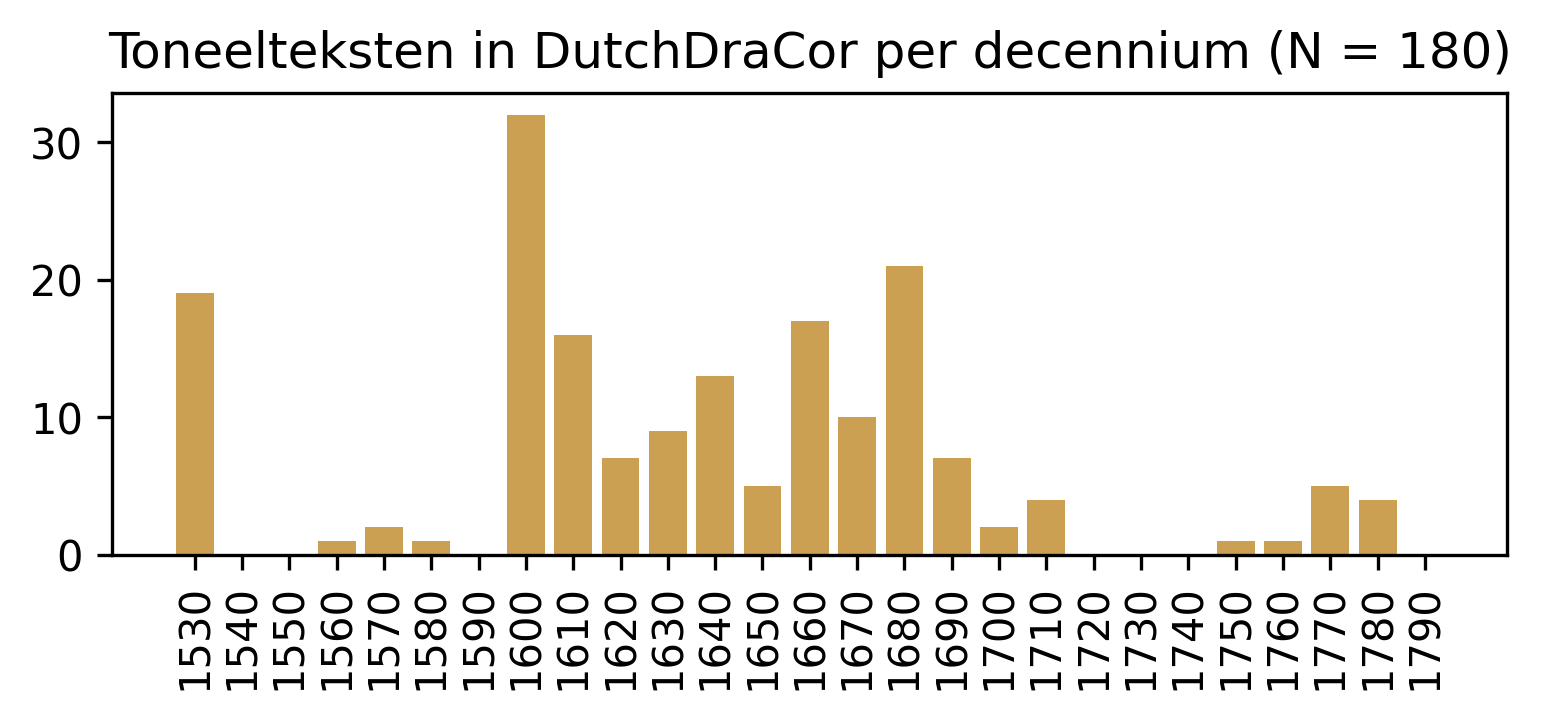

In [ ]:
decades = [str(decade) + "0" for decade in range(153,180)]
histogram = {}
for decade in decades:
  histogram[decade] = 0

print(histogram)

for year in df_plays["year"].tolist():
  if year != None:
    decade = str(year[0:3]) + "0"
    histogram[decade] += 1

x_labels = list(histogram.keys())
y_labels = list(histogram.values())

#print(y_labels)

fig = plt.figure(figsize=(6,2), dpi=300)

plt.bar(x_labels, y_labels, width=0.8, bottom=None, align='center', color="#cba052", data=None)
plt.xticks(rotation=90)
plt.title('Toneelteksten in DutchDraCor per decennium (N = 180)') #"Number of plays per decade (N = 180)"
plt.show()

#plt.savefig(output_folder + "plays_per_decade", bbox_inches='tight') #uncomment to save the image

In [ ]:
len([value for value in df_plays['%_male_lines'].tolist() if value >0.5])

81

<Figure size 900x1200 with 0 Axes>

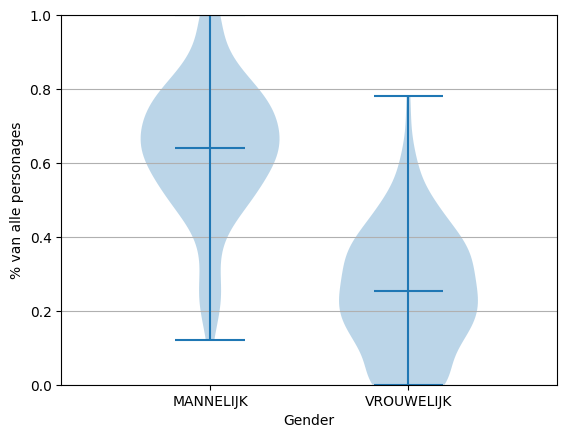

In [ ]:
fig = plt.figure(figsize=(3,4), dpi=300)

def set_axis_style(ax, labels):
    ax.set_xticks([1,2], labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Gender')

fig, axes = plt.subplots()

axes.violinplot(dataset = [df_plays['%_male_chars'],
                          df_plays['%_female_chars'],], showmeans=True, widths=0.7)

labels = ['MANNELIJK', 'VROUWELIJK']
for ax in [axes]:
    set_axis_style(ax, labels)

#axes.set_title('Proportion of male and female characters in each play')
axes.yaxis.grid(True)
axes.set_ylim(0,1)
#axes.set_xticks("")
#axes.set_xlabel('Scenario')
axes.set_ylabel('% van alle personages') #'% of all characters'

fig.show()
#plt.savefig(output_folder + "violinplot_male_female_chars.png", bbox_inches='tight') #uncomment to save the image

In [ ]:
axes

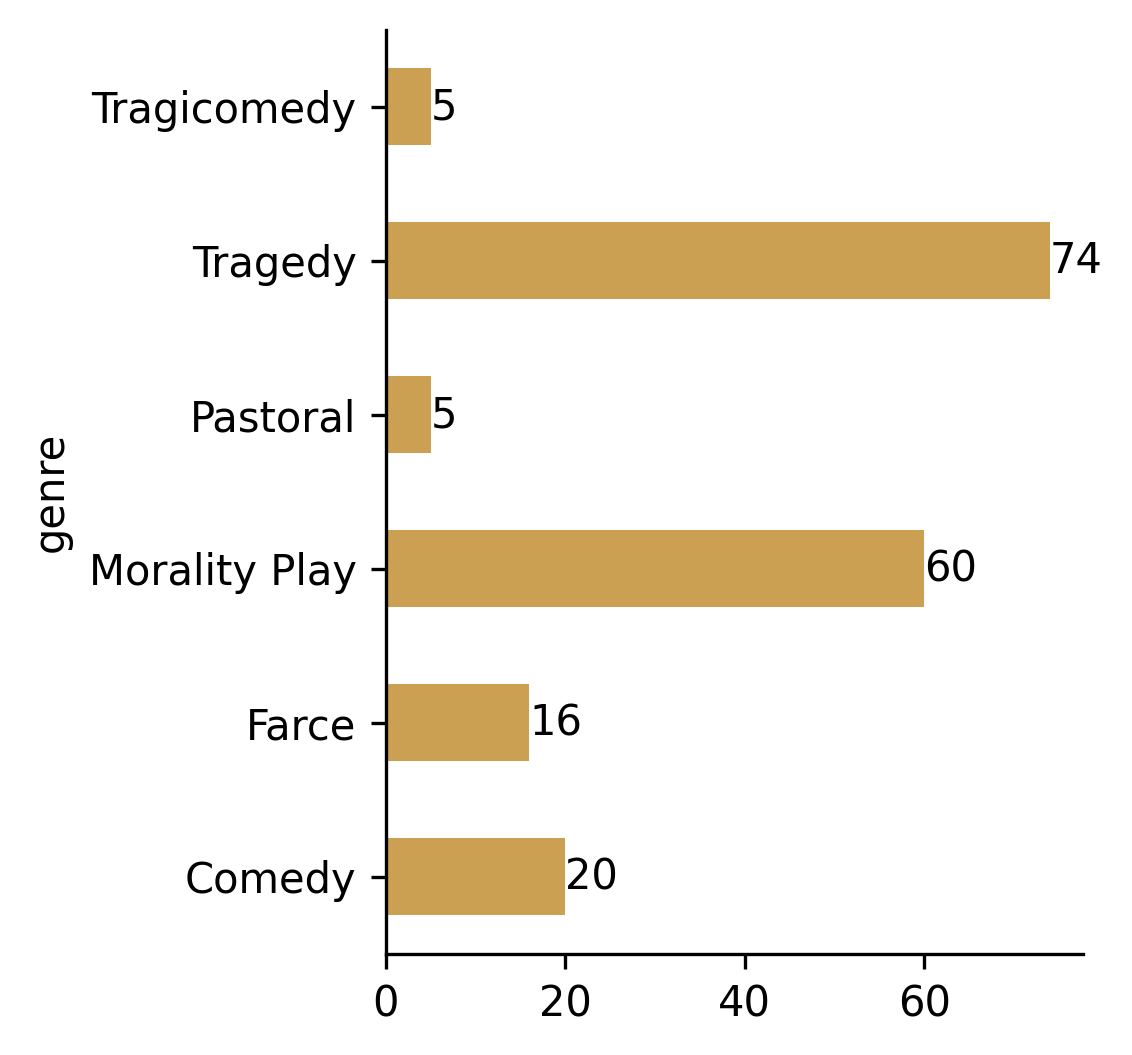

In [ ]:
# @title genre
fig = plt.figure(figsize=(3,4), dpi=300)

from matplotlib import pyplot as plt
import seaborn as sns
ax = df_plays.groupby('genre').size().plot(kind='barh', color=['#CBA052']) #sns.palettes.mpl_palette('Dark2')
plt.gca().spines[['top', 'right',]].set_visible(False)

ax.bar_label(ax.containers[0])

plt.show()

#plt.savefig(output_folder + "violinplot_male_female_lines.png", bbox_inches='tight') #uncomment to save the image

[Text(0, 0, '180')]

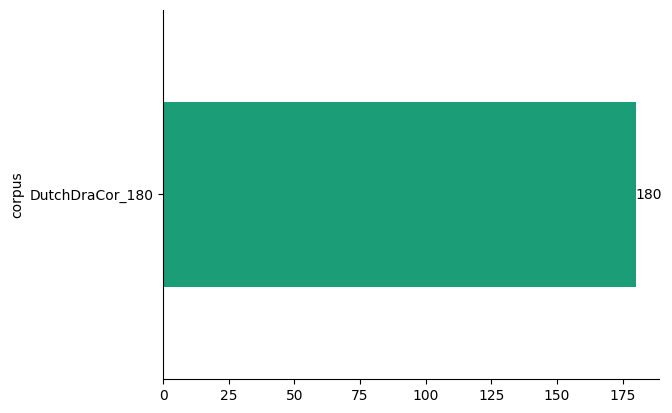

In [ ]:
# @title corpus

from matplotlib import pyplot as plt
import seaborn as sns
ax = df_plays.groupby('corpus').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


ax.bar_label(ax.containers[0])

Like most corpora, a drama corpus usually contains a lot of variation between plays and characters. We can visualise this variance in the dataset using boxplots. Boxplots allow us to inspect potential relationships between dependent variables (such as % of female characters, density and mean speech turn length) and independent variables (such as corpus, author or genre). Explore those relationships by redefining `dependent_var` and `independent_var` in the code block below.

In [ ]:
independent_var = 'gender'
dependent_var = '%_female_lines'

fig = plt.figure(figsize=(12,6), dpi=300)
boxplot = df_plays.boxplot(column=[dependent_var], by=[independent_var], figsize=(12,6))
#plt.savefig(output_folder + "boxplot_" + independent_var + "_" + dependent_var +".png", bbox_inches='tight') #uncomment to save the image

KeyError: 'gender'

<Figure size 3600x1800 with 0 Axes>

Chronological developments can be plottes as a line chart. Change the variable to be plotted on the y-axis to explore historical developments in the corpus, such as the percentage of female speech compared to all speech in the play. Please note that the corpus is still too limited to draw final conclusions on historical changes.

In [ ]:
1655-1539

116

<Figure size 3600x1800 with 0 Axes>

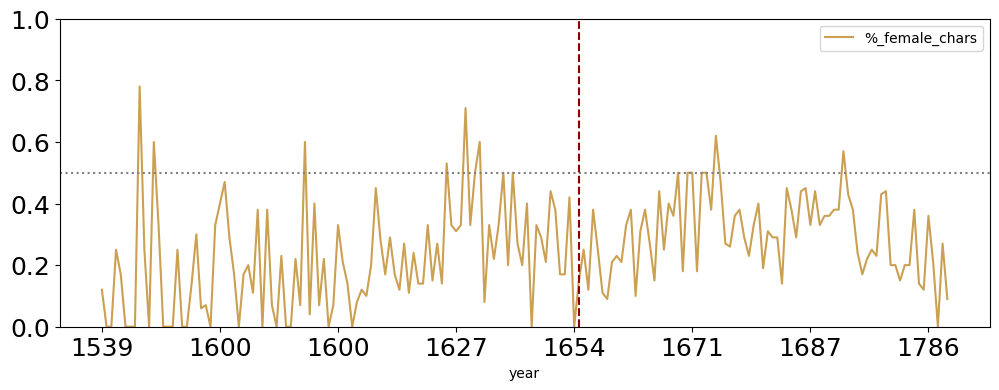

In [ ]:
variable1 = "%_female_chars"
#variable2 = "%_female_chars"

fig = plt.figure(figsize=(12,6), dpi=300)
line_chart1 = df_plays.sort_values('year').plot(x='year', y=[variable1], figsize=(12,4), color="#cba052", ylim=(0,1.0), fontsize=18)
plt.axhline(y = 0.5, color = 'grey', label = '50 %', linestyle="dotted")
plt.axvline(x = 101, color = 'darkred', label = '1655', linestyle="dashed")
#plt.savefig(output_folder + "linechart_" + variable +".png", bbox_inches='tight') #uncomment to save the image

Another way to visualise differences between plays, is to use rankings. Run the code block below to rank the corpus based on the selected `variable`. Change the variable `y_axis` to compare the rankings based on other bibliographic features, such as genre or author.

<Figure size 3600x3600 with 0 Axes>

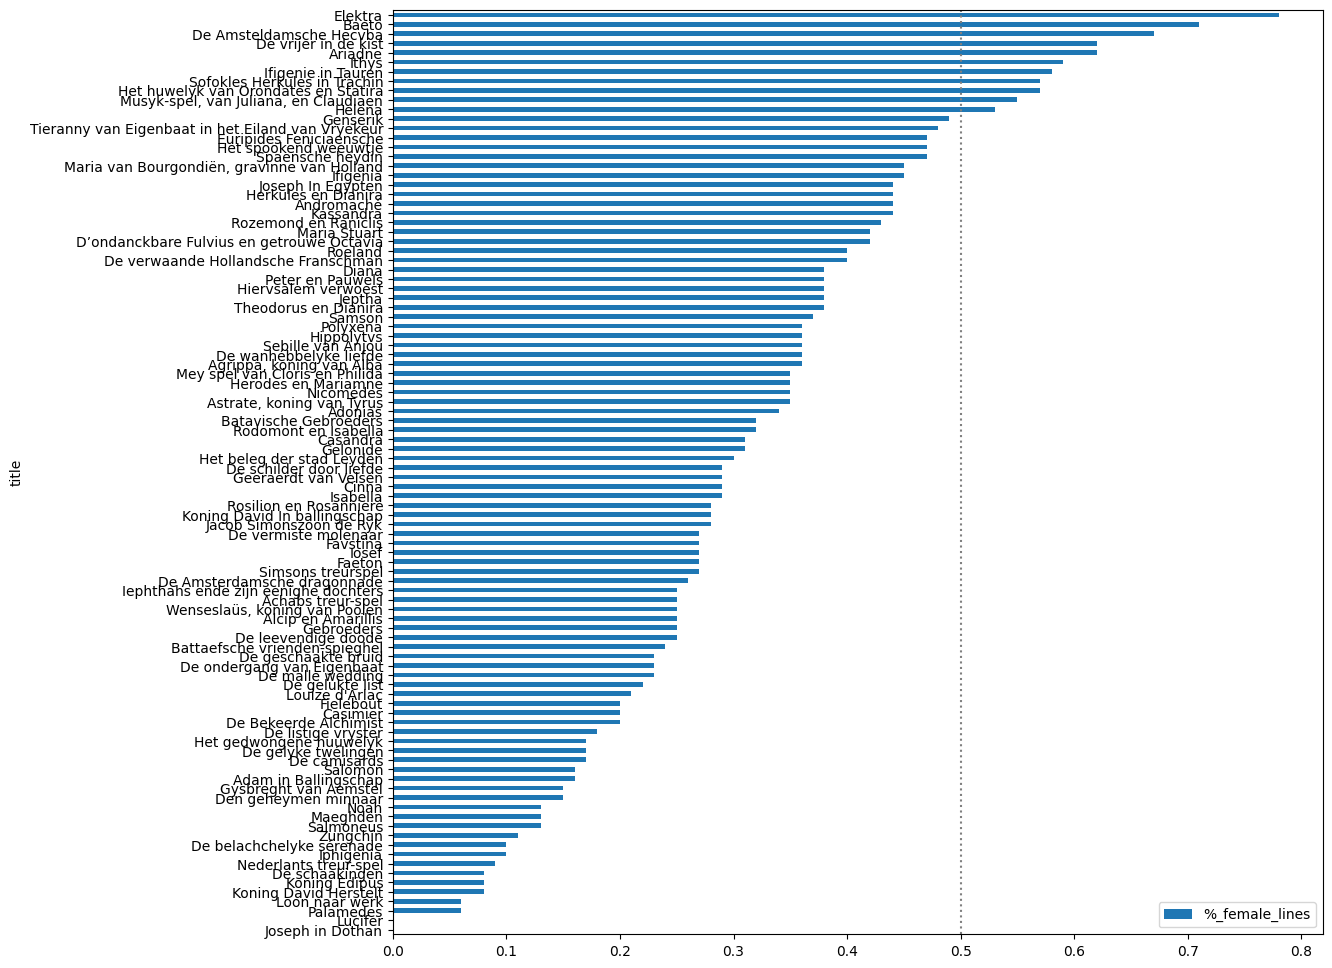

In [ ]:
variable = '%_female_lines'
y_axis = 'title'

fig = plt.figure(figsize=(12,12), dpi=300)
bar = df_plays.sort_values(variable).plot.barh(x=y_axis, y=variable, figsize=(12,12))
plt.axvline(x = 0.5, color = 'grey', label = '50 %', linestyle="dotted")

### 3.2 Comparing characters

Besides information about plays, we also have data about each character in the dataset:

In [ ]:
df_characters

Similar to the first table, we can visualise the variance in the character dataset using boxplots. There are many possibilities for comparing dependent and independent variables. Explore those possibilities by changing the variables `dependent_var`, `independent_var_1` and `independent_var_2`. Please note that it's optional to include a second independent variable, so you can also remove that from the list after `by=[X, Y]`.

In [ ]:
dependent_var = 'lines (rel)'
#independent_var_1 = 'corpus'
independent_var_2 = 'gender'

fig = plt.figure(figsize=(12,6), dpi=300)
boxplot = df_characters.violinplot(column=[dependent_var], by=[independent_var_2], rot=90, figsize=(12,6), showmeans=True)
#plt.savefig(output_folder + "boxplot_" + independent_var_1 + "_"  + independent_var_2 + "_" + dependent_var +".png", bbox_inches='tight') #uncomment to save the image

AttributeError: 'DataFrame' object has no attribute 'violinplot'

<Figure size 3600x1800 with 0 Axes>

In [ ]:
male_chars = len(df_characters[df_characters.gender == 'MALE'])
female_chars = len(df_characters[df_characters.gender == 'FEMALE'])

print(male_chars)
print(female_chars)

802
339


In [ ]:
variable = "degree (rel)"

print(sum(df_characters[df_characters.gender == 'MALE'][variable].values) / 802)
print(sum(df_characters[df_characters.gender == 'FEMALE'][variable].values) / 339)

0.542630922693266
0.598525073746313


In [ ]:
variable = 'tokens'

F_LINES = sum(df_characters[df_characters.gender == 'FEMALE'][variable].values)
M_LINES = sum(df_characters[df_characters.gender == 'MALE'][variable].values)

print(M_LINES)
print(F_LINES)

945949
448503


<Figure size 900x1200 with 0 Axes>

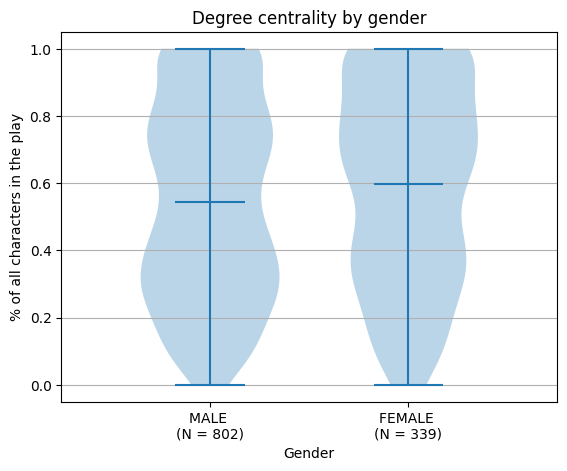

In [ ]:
fig = plt.figure(figsize=(3,4), dpi=300)
independent_var = 'degree (rel)'


def set_axis_style(ax, labels):
    ax.set_xticks([1,2], labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Gender')

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

fig, axes = plt.subplots()

axes.violinplot(dataset = [df_characters[df_characters.gender == 'MALE'][independent_var].values,
                           df_characters[df_characters.gender == 'FEMALE'][independent_var].values,], showmeans=True, widths=0.7 )

labels = ['MALE \n(N = 802)', 'FEMALE \n(N = 339)']
for ax in [axes]:
    set_axis_style(ax, labels)

axes.set_title('Degree centrality by gender')
axes.yaxis.grid(True)
#axes.set_xticks("")
#axes.set_xlabel('Scenario')
axes.set_ylabel('% of all characters in the play')

#plt.show()
plt.savefig(output_folder + "violinplot_male_female_centrality.png", bbox_inches='tight') #uncomment to save the image


In [ ]:
df_characters.loc[df_characters['gender'] == "MALE", 'male edges'].tolist()

[5,
 4,
 0,
 4,
 2,
 3,
 1,
 7,
 3,
 0,
 7,
 0,
 2,
 7,
 2,
 6,
 5,
 3,
 3,
 5,
 5,
 6,
 6,
 2,
 2,
 1,
 1,
 1,
 5,
 0,
 0,
 4,
 9,
 6,
 10,
 8,
 2,
 9,
 9,
 6,
 4,
 3,
 7,
 1,
 2,
 1,
 0,
 4,
 5,
 3,
 0,
 2,
 3,
 5,
 0,
 4,
 0,
 0,
 4,
 4,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 5,
 0,
 3,
 1,
 1,
 1,
 0,
 3,
 2,
 7,
 0,
 0,
 5,
 3,
 3,
 7,
 3,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 3,
 1,
 0,
 5,
 7,
 1,
 1,
 2,
 4,
 0,
 3,
 5,
 6,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 5,
 1,
 2,
 1,
 3,
 2,
 0,
 1,
 0,
 0,
 0,
 5,
 2,
 2,
 3,
 0,
 1,
 1,
 3,
 0,
 3,
 1,
 2,
 3,
 3,
 1,
 2,
 1,
 3,
 5,
 5,
 2,
 0,
 1,
 2,
 0,
 1,
 3,
 0,
 1,
 1,
 2,
 3,
 0,
 1,
 1,
 3,
 1,
 1,
 0,
 1,
 2,
 3,
 2,
 2,
 0,
 1,
 0,
 3,
 3,
 0,
 8,
 9,
 6,
 1,
 0,
 1,
 6,
 6,
 7,
 12,
 2,
 13,
 11,
 10,
 1,
 6,
 11,
 11,
 0,
 5,
 5,
 8,
 1,
 3,
 0,
 1,
 0,
 2,
 2,
 5,
 1,
 6,
 4,
 1,
 3,
 2,
 3,
 5,
 2,
 4,
 3,
 4,
 1,
 3,
 0,
 1,
 0,
 3,
 1,
 3,
 2,
 2,
 1,
 1,
 2,
 0,
 1,
 0,
 3,
 0,
 6,
 5,
 0,
 1,
 2,
 1,
 0,
 4,
 4,
 3,
 3,
 6,
 

In [ ]:
print("MALE TO MALE:", (df_characters.loc[df_characters['gender'] == "MALE", 'male edges']).sum())
print("FEMALE TO MALE:", (df_characters.loc[df_characters['gender'] == "MALE", 'female edges']).sum() + (df_characters.loc[df_characters['gender'] == "FEMALE", 'male edges']).sum())
print("FEMALE TO FEMALE:", (df_characters.loc[df_characters['gender'] == "FEMALE", 'female edges']).sum())

MALE TO MALE: 1937
FEMALE TO MALE: 1551
FEMALE TO FEMALE: 358


Furthermore, we can analyse correlations between numerical values. Change the variables `x_values` and `y_values` to explore potential correlations between continuous (numerical) variables.

<Figure size 3600x1800 with 0 Axes>

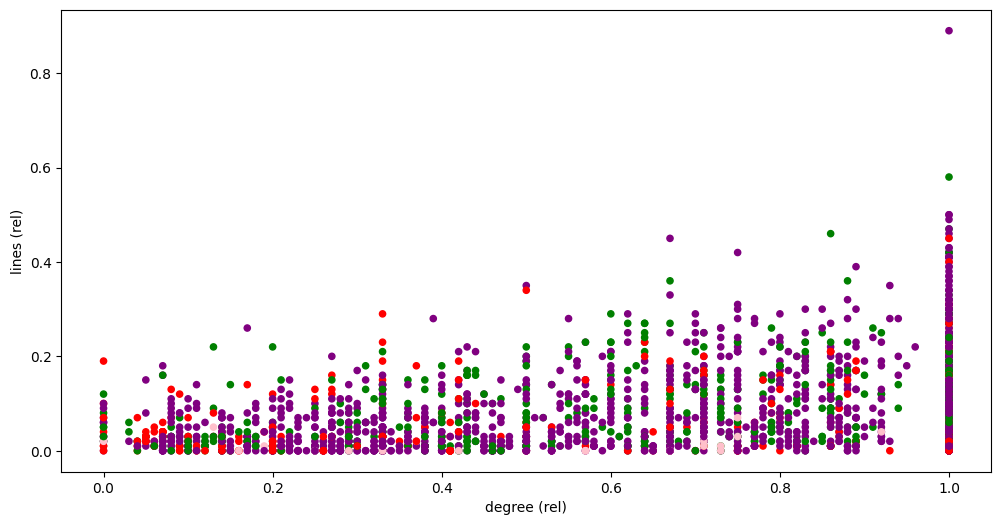

In [ ]:
x_values = 'degree (rel)'
y_values = 'lines (rel)'

colors = {
    'MALE': 'purple',
    'FEMALE': 'green',
    'UNKNOWN': 'red',
    'u': 'pink'
}
color_map = [colors[gender] for gender in list(df_characters['gender'])]

fig = plt.figure(figsize=(12,6), dpi=300)
ax = df_characters.plot.scatter(x=x_values, y=y_values, c=color_map, figsize=(12,6))
#plt.savefig(output_folder + "scatter_" + y_values + "_" + x_values +".png", bbox_inches='tight') #uncomment to save the image

Finally, we can save the two dataframes as csv-tables. Uncomment the two lines below to store the output in your personal folder.

In [ ]:
df_plays.to_csv(output_folder + ("_").join(corpora) + "_180_plays_metadata.csv")
df_characters.to_csv(output_folder + ("_").join(corpora) + "_180_characterdata.csv")